In [ ]:
!pip install mlforecast lightgbm statsforecast pandas


In [ ]:
import pandas as pd
import numpy as np

from statsforecast import StatsForecast
from statsforecast.models import AutoETS, AutoARIMA

from mlforecast import MLForecast
from lightgbm import LGBMRegressor


In [ ]:
from google.colab import files
uploaded = files.upload()
df["ds"] = pd.to_datetime(df["ds"])


Saving sample_hotels.parquet to sample_hotels (3).parquet


In [ ]:
def make_folds(df, n_folds=5, fold_size=None):
    if fold_size is None:
        fold_size = len(df) // (n_folds + 1)

    folds = []
    for i in range(1, n_folds + 1):
        train_end = fold_size * i
        train_idx = list(range(0, train_end))
        val_idx = list(range(train_end, train_end + fold_size))
        if len(val_idx) > 0:
            folds.append((train_idx, val_idx))
    return folds


In [ ]:
def mae(y, yhat):
    return np.mean(np.abs(y - yhat))

def rmse(y, yhat):
    return np.sqrt(np.mean((y - yhat)**2))

def me(y, yhat):
    return np.mean(y - yhat)


In [ ]:
def naive_predict(df, train_idx, val_idx):
    last_val = df["y"].iloc[train_idx[-1]]
    return np.repeat(last_val, len(val_idx))

def seasonal_naive_predict(df, train_idx, val_idx, season=7):
    return df["y"].iloc[train_idx[-season]].repeat(len(val_idx))


In [ ]:
def ets_predict(df, train_idx, val_idx):
    h = len(val_idx)
    train_df = df.iloc[train_idx][["unique_id", "ds", "y"]]

    model = StatsForecast(
        models=[AutoETS(season_length=7)],
        freq="D"
    )
    model.fit(train_df)

    fcst = model.predict(h=h)
    return fcst["AutoETS"].values


In [ ]:
def arima_predict(df, train_idx, val_idx):
    h = len(val_idx)
    train_df = df.iloc[train_idx][["unique_id", "ds", "y"]]

    model = StatsForecast(
        models=[AutoARIMA()],
        freq="D"
    )
    model.fit(train_df)

    fcst = model.predict(h=h)
    return fcst["AutoARIMA"].values


In [ ]:
from sklearn.preprocessing import LabelEncoder

df_lgb = df.copy()
categoricals = []

for col in df_lgb.columns:
    if df_lgb[col].dtype == "object" and col not in ["unique_id"]:
        categoricals.append(col)
        df_lgb[col] = LabelEncoder().fit_transform(df_lgb[col])


In [ ]:
def lightgbm_predict(df_series, train_idx, val_idx):
    train = df_lgb.iloc[train_idx]
    val = df_lgb.iloc[val_idx]

    model = LGBMRegressor()
    model.fit(train.drop(columns=["y","ds"]), train["y"])

    return model.predict(val.drop(columns=["y","ds"]))


In [ ]:
results = []

hotels = df["unique_id"].unique()

for hotel in hotels:
    df_h = df[df["unique_id"] == hotel].reset_index(drop=True)
    folds = make_folds(df_h)

    for fold_num, (train_idx, val_idx) in enumerate(folds, 1):

        y_val = df_h["y"].iloc[val_idx].values
        row = {"hotel": hotel, "fold": fold_num}


        pred = naive_predict(df_h, train_idx, val_idx)
        row["Naive_ME"]   = me(y_val, pred)
        row["Naive_MAE"]  = mae(y_val, pred)
        row["Naive_RMSE"] = rmse(y_val, pred)
        row["Naive_MAPE"] = mape(y_val, pred)


        pred = seasonal_naive_predict(df_h, train_idx, val_idx)
        row["Seasonal_ME"]   = me(y_val, pred)
        row["Seasonal_MAE"]  = mae(y_val, pred)
        row["Seasonal_RMSE"] = rmse(y_val, pred)
        row["Seasonal_MAPE"] = mape(y_val, pred)


        pred = ets_predict(df_h, train_idx, val_idx)
        row["ETS_ME"]   = me(y_val, pred)
        row["ETS_MAE"]  = mae(y_val, pred)
        row["ETS_RMSE"] = rmse(y_val, pred)
        row["ETS_MAPE"] = mape(y_val, pred)

        pred = arima_predict(df_h, train_idx, val_idx)
        row["ARIMA_ME"]   = me(y_val, pred)
        row["ARIMA_MAE"]  = mae(y_val, pred)
        row["ARIMA_RMSE"] = rmse(y_val, pred)
        row["ARIMA_MAPE"] = mape(y_val, pred)


        try:
            pred = lightgbm_predict(df_h, train_idx, val_idx)
            row["LGBM_ME"]   = me(y_val, pred)
            row["LGBM_MAE"]  = mae(y_val, pred)
            row["LGBM_RMSE"] = rmse(y_val, pred)
            row["LGBM_MAPE"] = mape(y_val, pred)
        except:
            row["LGBM_ME"]   = None
            row["LGBM_MAE"]  = None
            row["LGBM_RMSE"] = None
            row["LGBM_MAPE"] = None


        row["NBEATS_ME"]   = None
        row["NBEATS_MAE"]  = None
        row["NBEATS_RMSE"] = None
        row["NBEATS_MAPE"] = None

        row["NHITS_ME"]   = None
        row["NHITS_MAE"]  = None
        row["NHITS_RMSE"] = None
        row["NHITS_MAPE"] = None

        results.append(row)


/tmp/ipython-input-754208988.py:11: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y - yhat) / y))
/tmp/ipython-input-754208988.py:11: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y - yhat) / y))
/tmp/ipython-input-754208988.py:11: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y - yhat) / y))
/tmp/ipython-input-754208988.py:11: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y - yhat) / y))
/tmp/ipython-input-754208988.py:11: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y - yhat) / y))
/tmp/ipython-input-754208988.py:11: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y - yhat) / y))
/tmp/ipython-input-754208988.py:11: RuntimeWarning: invalid value encountered in divide
  return np.mean(np.abs((y - yhat) / y))
/tmp/ipython-input-754208988.py:11: RuntimeWarning: divide by zero encountered in divide
  

In [ ]:
results_df = pd.DataFrame(results)
results_df


,hotel,fold,Naive_ME,Naive_MAE,Naive_RMSE,Naive_MAPE,Seasonal_ME,Seasonal_MAE,Seasonal_RMSE,Seasonal_MAPE,...,LGBM_RMSE,LGBM_MAPE,NBEATS_ME,NBEATS_MAE,NBEATS_RMSE,NBEATS_MAPE,NHITS_ME,NHITS_MAE,NHITS_RMSE,NHITS_MAPE
0,hotel_0,1,-0.144621,0.144621,0.213324,0.221939,-0.132275,0.138244,0.205155,0.212709,...,None,None,None,None,None,None,None,None,None,None
1,hotel_0,2,-0.200787,0.207299,0.277667,0.392666,-0.225478,0.225478,0.296014,0.421598,...,None,None,None,None,None,None,None,None,None,None
2,hotel_0,3,0.480125,0.480125,0.536835,0.620936,-0.272962,0.272962,0.363565,0.596059,...,None,None,None,None,None,None,None,None,None,None
3,hotel_0,4,-0.198209,0.198752,0.276412,0.361783,0.431420,0.432777,0.472483,0.510714,...,None,None,None,None,None,None,None,None,None,None
4,hotel_0,5,-0.288699,0.289513,0.343984,0.549869,-0.301045,0.301587,0.354409,0.568968,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,hotel_98,1,-0.191776,0.209323,0.223746,2.285530,-0.457905,0.457905,0.472188,4.693392,...,None,None,None,None,None,None,None,None,None,None
91,hotel_98,2,0.043602,0.100496,0.151582,1.037665,-0.069302,0.138072,0.160869,2.354963,...,None,None,None,None,None,None,None,None,None,None
92,hotel_98,3,0.044045,0.120968,0.169620,inf,-0.028536,0.139135,0.166269,inf,...,None,None,None,None,None,None,None,None,None,None
93,hotel_98,4,-0.359181,0.360245,0.390299,2.028914,0.116625,0.133463,0.192155,0.383038,...,None,None,None,None,None,None,None,None,None,None


In [ ]:
metrics = ["Naive_MAE", "Seasonal_MAE", "ETS_MAE", "ARIMA_MAE", "LGBM_MAE"]

results_df["Winner"] = results_df[metrics].idxmin(axis=1)

win_counts = results_df["Winner"].value_counts()
win_counts



,count
Winner,
ETS_MAE,37
Naive_MAE,22
Seasonal_MAE,19
ARIMA_MAE,17


In [ ]:
results_df.to_csv("evaluation_folds.csv", index=False)
print("Saved evaluation_folds.csv")


Saved evaluation_folds.csv


In [ ]:
summary_df = results_df.groupby("hotel").mean(numeric_only=True)
summary_df.to_csv("evaluation_summary.csv")
summary_df


,fold,Naive_ME,Naive_MAE,Naive_RMSE,Naive_MAPE,Seasonal_ME,Seasonal_MAE,Seasonal_RMSE,Seasonal_MAPE,ETS_ME,ETS_MAE,ETS_RMSE,ETS_MAPE,ARIMA_ME,ARIMA_MAE,ARIMA_RMSE,ARIMA_MAPE
hotel,,,,,,,,,,,,,,,,,
hotel_0,3.0,-0.070438,0.264062,0.329644,0.429438,-0.100068,0.274210,0.338325,0.462009,0.016016,0.223500,0.268748,0.348397,-0.053888,0.247897,0.290235,0.367729
hotel_105,3.0,-0.040583,0.200484,0.234301,0.299552,-0.041841,0.150764,0.188061,0.224951,0.016042,0.211579,0.247671,0.298926,-0.080373,0.183475,0.220798,0.281511
hotel_112,3.0,0.106786,0.179396,0.206102,0.207509,0.080536,0.138036,0.159417,0.159491,0.018932,0.113247,0.137623,0.136877,0.006825,0.103853,0.126639,0.127450
hotel_126,3.0,-0.041548,0.051600,0.094934,0.067772,-0.026409,0.053868,0.089803,0.068145,0.007487,0.073523,0.101285,0.086298,-0.022566,0.056420,0.091173,0.071390
hotel_133,3.0,-0.126464,0.141164,0.184022,0.216612,-0.087119,0.144911,0.185756,0.208907,-0.062146,0.110008,0.142489,0.166716,-0.108977,0.161382,0.193941,0.231286
hotel_14,3.0,-0.040680,0.122662,0.151501,0.191911,-0.123699,0.176778,0.212367,0.278915,0.009371,0.113585,0.136207,0.164569,-0.000265,0.114320,0.139311,0.173732
hotel_21,3.0,0.066046,0.119851,0.149508,0.141557,0.005861,0.074461,0.102309,0.090275,0.063481,0.120930,0.148356,0.142666,0.076878,0.127035,0.154067,0.147975
hotel_28,3.0,-0.057711,0.131813,0.177288,inf,-0.204377,0.215549,0.254687,inf,-0.011951,0.134902,0.180130,inf,-0.047177,0.174729,0.206375,inf
hotel_35,3.0,0.041565,0.170669,0.204969,0.752187,-0.044372,0.142329,0.170798,0.819873,-0.039580,0.257311,0.311178,1.077160,0.046087,0.164366,0.199949,0.684129


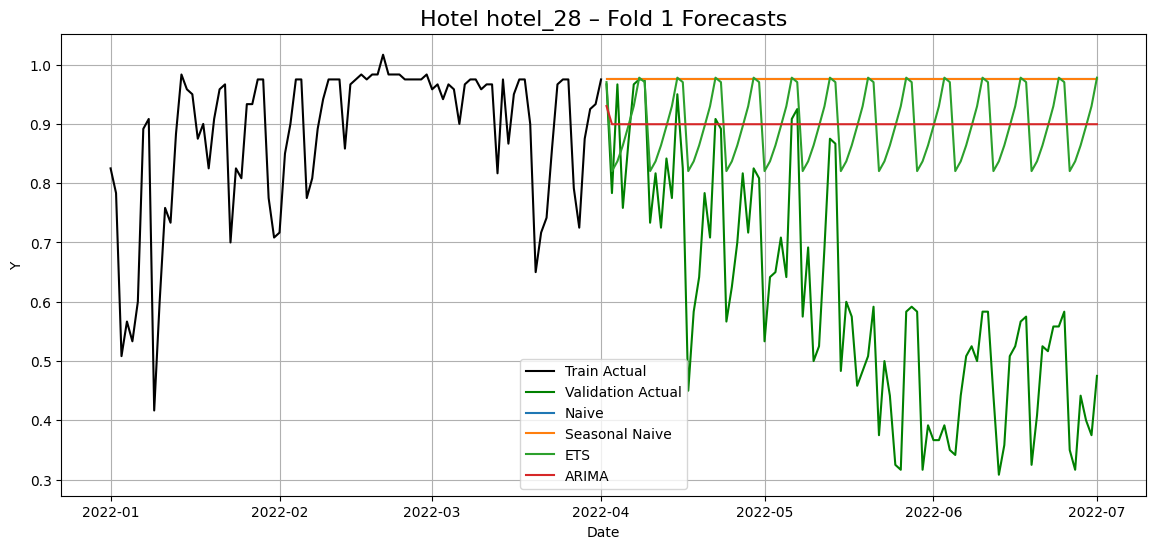

In [ ]:
hotel = "hotel_28"

df_h = df[df["unique_id"] == hotel].copy().reset_index(drop=True)
df_h["unique_id"] = hotel

folds = make_folds(df_h)
train_idx, val_idx = folds[0]

preds = {}
preds["Naive"] = naive_predict(df_h, train_idx, val_idx)
preds["Seasonal Naive"] = seasonal_naive_predict(df_h, train_idx, val_idx)
preds["ETS"] = ets_predict(df_h, train_idx, val_idx)
preds["ARIMA"] = arima_predict(df_h, train_idx, val_idx)

plot_forecast(
    df_h,
    train_idx,
    val_idx,
    preds,
    title=f"Hotel {hotel} – Fold 1 Forecasts"
)


In [85]:
final_forecasts = []

H = 28

for hotel in df["unique_id"].unique():

    df_h = df[df["unique_id"] == hotel].copy().reset_index(drop=True)



    forecasts = {"hotel": hotel}


    naive_pred = df_h["y"].iloc[-1]
    forecasts["Naive"] = [naive_pred] * H


    try:
        seasonal_pred = df_h["y"].iloc[-7:]
        forecasts["SeasonalNaive"] = list(seasonal_pred.values) * (H//7 + 1)
    except:
        forecasts["SeasonalNaive"] = [naive_pred] * H


    try:
        df_fc_ets = StatsForecast(
            models=[AutoETS(season_length=7)],
            freq="D"
        ).forecast(df=df_h[["unique_id","ds","y"]], h=H)
        forecasts["ETS"] = df_fc_ets["AutoETS"].tolist()
    except:
        forecasts["ETS"] = None


    try:
        df_fc_arima = StatsForecast(
            models=[AutoARIMA(season_length=7)],
            freq="D"
        ).forecast(df=df_h[["unique_id","ds","y"]], h=H)
        forecasts["ARIMA"] = df_fc_arima["AutoARIMA"].tolist()
    except:
        forecasts["ARIMA"] = None


    try:
        preds_lgb = lightgbm_predict(df_h, list(range(len(df_h))), [])
        forecasts["LightGBM"] = preds_lgb[:H]
    except:
        forecasts["LightGBM"] = None

    final_forecasts.append(forecasts)


final_fc_df = pd.DataFrame(final_forecasts)
final_fc_df.to_csv("final_28day_forecasts.csv", index=False)

final_fc_df


,hotel,Naive,SeasonalNaive,ETS,ARIMA,LightGBM
0,hotel_0,"[0.8271604938271605, 0.8271604938271605, 0.827...","[0.9506172839506173, 0.5061728395061729, 0.580...","[0.8542002171862775, 0.6258887772485338, 0.646...","[0.8894995990534879, 0.6525592801429422, 0.646...",None
1,hotel_105,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.9874213836477987, 0.9937106918238994, 1.018...","[1.0476449387846933, 0.9616544656744862, 1.007...","[0.9858242225962766, 0.9937180425997397, 1.006...",None
2,hotel_112,"[0.96875, 0.96875, 0.96875, 0.96875, 0.96875, ...","[0.75625, 0.7625, 0.76875, 0.8625, 0.89375, 1....","[0.903436796126748, 0.8684008104548067, 0.9192...","[0.9282027722244105, 0.8991028633345858, 0.900...",None
3,hotel_126,"[0.9880478087649402, 0.9880478087649402, 0.988...","[1.00398406374502, 1.00398406374502, 1.0039840...","[1.0118542902214969, 0.9755733507879766, 0.954...","[0.9901987417586503, 0.9946131490617062, 0.995...",None
4,hotel_133,"[0.9672131147540983, 0.9672131147540983, 0.967...","[1.0163934426229508, 0.8852459016393442, 0.983...","[1.007238888108479, 0.831348347201812, 0.86433...","[0.9868188746797321, 0.9083265961004361, 0.937...",None
5,hotel_14,"[0.5188679245283019, 0.5188679245283019, 0.518...","[0.6132075471698113, 0.5660377358490566, 0.594...","[0.6313797479282144, 0.41167666920525214, 0.51...","[0.5506045370049126, 0.5454823650301845, 0.574...",None
6,hotel_21,"[0.9074074074074074, 0.9074074074074074, 0.907...","[1.0, 0.9166666666666666, 0.9861111111111112, ...","[0.9374724566382746, 0.8925108438409023, 0.899...","[0.9279539564813695, 0.924042332493099, 0.9400...",None
7,hotel_28,"[0.6083333333333333, 0.6083333333333333, 0.608...","[0.008333333333333333, 0.008333333333333333, 0...","[0.45199125065461343, 0.45545059670535654, 0.4...","[0.42155823011429544, 0.2946640323508257, 0.22...",None
8,hotel_35,"[0.6953125, 0.6953125, 0.6953125, 0.6953125, 0...","[0.72265625, 0.7421875, 0.8359375, 0.919921875...","[0.6292694250088536, 0.6360961863349548, 0.700...","[0.652510720739337, 0.668938409153805, 0.74841...",None
9,hotel_42,"[0.7611336032388664, 0.7611336032388664, 0.761...","[0.902834008097166, 0.38461538461538464, 0.724...","[0.9032813225244133, 0.5510395344140244, 0.637...","[0.7751276091367173, 0.5139804523067291, 0.618...",None
